In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data="/content/drive/MyDrive/Datasets/Lung-CT-data"

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# **`PreProcessing`**

In [ ]:
training_data=tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False)


validation_data=tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 271 files belonging to 2 classes.
Using 244 files for training.
Found 271 files belonging to 2 classes.
Using 27 files for validation.


In [ ]:
class_names=training_data.class_names
class_names

['CC', 'CN-benign']

In [ ]:
"""datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    validation_split=0.0,
    dtype=tf.float32
)


train_generator=datagen.flow_from_directory(
    data,
    target_size=(28,28),
    batch_size=2,
    color_mode='grayscale',
    class_mode='sparse',
    shuffle=True,
    seed=123
    )
train_generator"""

"datagen=ImageDataGenerator(\n    rescale=1./255,\n    data_format='channels_last',\n    validation_split=0.0,\n    dtype=tf.float32\n)\n\n\ntrain_generator=datagen.flow_from_directory(\n    data,\n    target_size=(28,28),\n    batch_size=2,\n    color_mode='grayscale',\n    class_mode='sparse',\n    shuffle=True,\n    seed=123\n    )\ntrain_generator"

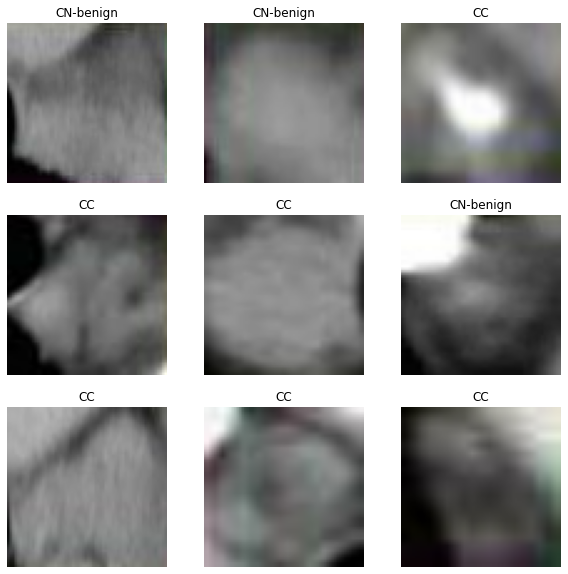

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in validation_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in training_data.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


# **`GAN Using PyTorch`**

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(os.listdir(data))

['CC', 'CN-benign']


In [ ]:
print(os.listdir(data+'/CC')[:10])

['CC27.jpg', 'CC1.jpg', 'CC8.jpg', 'CC22.jpg', 'CC13.jpg', 'CC21.jpg', 'CC16.jpg', 'CC19.jpg', 'CC4.jpg', 'CC10.jpg']


In [ ]:
image_size = 64
batch_size = 8
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(data, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


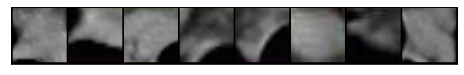

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([8, 3, 64, 64])


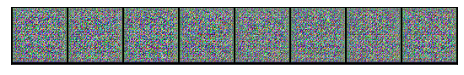

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


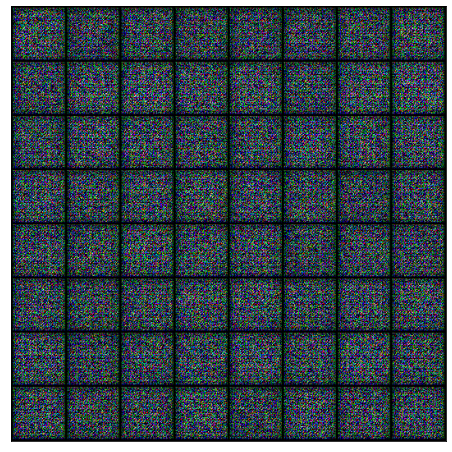

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 100

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/34 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/100], loss_g: 7.9295, loss_d: 0.0186, real_score: 0.9969, fake_score: 0.0153
Saving generated-images-0001.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 8.2459, loss_d: 0.0067, real_score: 0.9977, fake_score: 0.0044
Saving generated-images-0002.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 8.6636, loss_d: 0.0092, real_score: 0.9999, fake_score: 0.0091
Saving generated-images-0003.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 7.7247, loss_d: 0.0372, real_score: 0.9715, fake_score: 0.0062
Saving generated-images-0004.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 7.6579, loss_d: 0.0022, real_score: 0.9985, fake_score: 0.0007
Saving generated-images-0005.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 7.4555, loss_d: 0.0077, real_score: 0.9930, fake_score: 0.0006
Saving generated-images-0006.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 4.2297, loss_d: 0.0242, real_score: 0.9969, fake_score: 0.0209
Saving generated-images-0007.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 6.1598, loss_d: 0.0323, real_score: 0.9732, fake_score: 0.0046
Saving generated-images-0008.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 6.2369, loss_d: 0.0203, real_score: 0.9878, fake_score: 0.0078
Saving generated-images-0009.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 6.3329, loss_d: 0.0079, real_score: 0.9975, fake_score: 0.0054
Saving generated-images-0010.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 5.4648, loss_d: 0.0316, real_score: 0.9993, fake_score: 0.0302
Saving generated-images-0011.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 6.0724, loss_d: 0.0082, real_score: 0.9955, fake_score: 0.0037
Saving generated-images-0012.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 6.0133, loss_d: 0.0040, real_score: 0.9997, fake_score: 0.0036
Saving generated-images-0013.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 5.9060, loss_d: 0.0076, real_score: 0.9955, fake_score: 0.0031
Saving generated-images-0014.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 6.0993, loss_d: 0.0075, real_score: 0.9996, fake_score: 0.0071
Saving generated-images-0015.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 6.3623, loss_d: 0.0059, real_score: 0.9972, fake_score: 0.0031
Saving generated-images-0016.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 8.1170, loss_d: 0.0007, real_score: 0.9999, fake_score: 0.0006
Saving generated-images-0017.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 7.2611, loss_d: 0.0044, real_score: 0.9970, fake_score: 0.0014
Saving generated-images-0018.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 6.7395, loss_d: 0.0012, real_score: 1.0000, fake_score: 0.0012
Saving generated-images-0019.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 7.2516, loss_d: 0.0021, real_score: 0.9995, fake_score: 0.0016
Saving generated-images-0020.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 6.5275, loss_d: 0.0035, real_score: 0.9995, fake_score: 0.0029
Saving generated-images-0021.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 6.8573, loss_d: 0.0029, real_score: 0.9996, fake_score: 0.0025
Saving generated-images-0022.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 7.0621, loss_d: 0.0026, real_score: 0.9992, fake_score: 0.0018
Saving generated-images-0023.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 7.6086, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-0024.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 7.7884, loss_d: 0.0016, real_score: 0.9997, fake_score: 0.0013
Saving generated-images-0025.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 8.7624, loss_d: 0.0006, real_score: 0.9995, fake_score: 0.0001
Saving generated-images-0026.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 7.9050, loss_d: 0.0005, real_score: 0.9999, fake_score: 0.0005
Saving generated-images-0027.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 7.1476, loss_d: 0.0018, real_score: 0.9994, fake_score: 0.0011
Saving generated-images-0028.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 8.5400, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0029.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 7.7346, loss_d: 0.0010, real_score: 0.9994, fake_score: 0.0004
Saving generated-images-0030.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 8.2018, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0003
Saving generated-images-0031.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 7.8686, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0032.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 7.9996, loss_d: 0.0010, real_score: 0.9998, fake_score: 0.0008
Saving generated-images-0033.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 7.1789, loss_d: 0.0176, real_score: 0.9839, fake_score: 0.0010
Saving generated-images-0034.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 0.9025, loss_d: 0.9534, real_score: 0.7039, fake_score: 0.3795
Saving generated-images-0035.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 1.7420, loss_d: 0.3156, real_score: 0.9514, fake_score: 0.2141
Saving generated-images-0036.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 5.0646, loss_d: 0.1720, real_score: 0.9730, fake_score: 0.1276
Saving generated-images-0037.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.7222, loss_d: 0.1701, real_score: 0.9033, fake_score: 0.0453
Saving generated-images-0038.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 2.9114, loss_d: 0.2356, real_score: 0.8689, fake_score: 0.0541
Saving generated-images-0039.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 6.2345, loss_d: 0.3997, real_score: 0.8955, fake_score: 0.2200
Saving generated-images-0040.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 2.9674, loss_d: 0.4985, real_score: 0.8003, fake_score: 0.1904
Saving generated-images-0041.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 4.4294, loss_d: 0.3274, real_score: 0.7409, fake_score: 0.0029
Saving generated-images-0042.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 8.0737, loss_d: 0.1020, real_score: 0.9147, fake_score: 0.0023
Saving generated-images-0043.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 4.3831, loss_d: 0.0561, real_score: 0.9887, fake_score: 0.0418
Saving generated-images-0044.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.8718, loss_d: 1.8432, real_score: 0.3415, fake_score: 0.0190
Saving generated-images-0045.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 6.4796, loss_d: 0.4298, real_score: 0.9838, fake_score: 0.3082
Saving generated-images-0046.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 2.9063, loss_d: 0.2585, real_score: 0.9513, fake_score: 0.1668
Saving generated-images-0047.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.4840, loss_d: 0.8421, real_score: 0.5112, fake_score: 0.0320
Saving generated-images-0048.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 3.2600, loss_d: 0.3691, real_score: 0.9231, fake_score: 0.2087
Saving generated-images-0049.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 3.3422, loss_d: 1.9215, real_score: 0.9988, fake_score: 0.7762
Saving generated-images-0050.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.0616, loss_d: 0.2990, real_score: 0.8700, fake_score: 0.0962
Saving generated-images-0051.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 1.8688, loss_d: 0.7472, real_score: 0.8781, fake_score: 0.3597
Saving generated-images-0052.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 2.9303, loss_d: 0.6907, real_score: 0.8457, fake_score: 0.3277
Saving generated-images-0053.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 1.7775, loss_d: 1.5282, real_score: 0.9960, fake_score: 0.6713
Saving generated-images-0054.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 2.6485, loss_d: 0.3331, real_score: 0.8544, fake_score: 0.1483
Saving generated-images-0055.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 2.4278, loss_d: 0.5845, real_score: 0.7508, fake_score: 0.2376
Saving generated-images-0056.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 0.9814, loss_d: 1.1622, real_score: 0.4658, fake_score: 0.1712
Saving generated-images-0057.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.0997, loss_d: 0.7410, real_score: 0.7965, fake_score: 0.3604
Saving generated-images-0058.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 1.8246, loss_d: 0.6624, real_score: 0.7806, fake_score: 0.2739
Saving generated-images-0059.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 0.6912, loss_d: 0.6066, real_score: 0.6755, fake_score: 0.1214
Saving generated-images-0060.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 1.9654, loss_d: 0.5783, real_score: 0.7574, fake_score: 0.2420
Saving generated-images-0061.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 2.4488, loss_d: 0.4620, real_score: 0.9270, fake_score: 0.3083
Saving generated-images-0062.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 2.9031, loss_d: 0.8071, real_score: 0.6465, fake_score: 0.2611
Saving generated-images-0063.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 1.0760, loss_d: 0.6272, real_score: 0.6448, fake_score: 0.1233
Saving generated-images-0064.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 1.9724, loss_d: 0.7934, real_score: 0.5586, fake_score: 0.0983
Saving generated-images-0065.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 2.3206, loss_d: 1.0706, real_score: 0.4492, fake_score: 0.1558
Saving generated-images-0066.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 3.8286, loss_d: 1.6159, real_score: 0.9398, fake_score: 0.6939
Saving generated-images-0067.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 2.4512, loss_d: 0.5906, real_score: 0.7453, fake_score: 0.2344
Saving generated-images-0068.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 0.2518, loss_d: 2.6442, real_score: 0.1619, fake_score: 0.0245
Saving generated-images-0069.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 3.5643, loss_d: 0.9252, real_score: 0.7168, fake_score: 0.3716
Saving generated-images-0070.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 2.5135, loss_d: 1.0741, real_score: 0.7849, fake_score: 0.4622
Saving generated-images-0071.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 1.2729, loss_d: 0.7484, real_score: 0.5817, fake_score: 0.1186
Saving generated-images-0072.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 1.0440, loss_d: 0.5130, real_score: 0.7437, fake_score: 0.1668
Saving generated-images-0073.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 3.8887, loss_d: 0.6275, real_score: 0.9299, fake_score: 0.3950
Saving generated-images-0074.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 1.6006, loss_d: 0.3287, real_score: 0.8386, fake_score: 0.1313
Saving generated-images-0075.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 2.7550, loss_d: 1.4165, real_score: 0.9425, fake_score: 0.6869
Saving generated-images-0076.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 1.8485, loss_d: 0.4257, real_score: 0.8969, fake_score: 0.2604
Saving generated-images-0077.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 2.7807, loss_d: 0.6844, real_score: 0.9840, fake_score: 0.4480
Saving generated-images-0078.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.4223, loss_d: 0.9696, real_score: 0.4549, fake_score: 0.0239
Saving generated-images-0079.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 1.4802, loss_d: 0.7380, real_score: 0.5691, fake_score: 0.0362
Saving generated-images-0080.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 5.0510, loss_d: 0.1109, real_score: 0.9325, fake_score: 0.0386
Saving generated-images-0081.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.0914, loss_d: 0.4189, real_score: 0.8998, fake_score: 0.2391
Saving generated-images-0082.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.8806, loss_d: 0.8010, real_score: 0.6365, fake_score: 0.2472
Saving generated-images-0083.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.3972, loss_d: 0.1726, real_score: 0.8910, fake_score: 0.0510
Saving generated-images-0084.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 2.6177, loss_d: 0.7031, real_score: 0.7726, fake_score: 0.3130
Saving generated-images-0085.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 2.2239, loss_d: 0.8368, real_score: 0.5115, fake_score: 0.0761
Saving generated-images-0086.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 4.8374, loss_d: 0.8803, real_score: 0.9267, fake_score: 0.5086
Saving generated-images-0087.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 6.0287, loss_d: 1.8899, real_score: 0.9833, fake_score: 0.8136
Saving generated-images-0088.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 2.5175, loss_d: 0.1304, real_score: 0.9165, fake_score: 0.0399
Saving generated-images-0089.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 1.0884, loss_d: 1.3173, real_score: 0.3880, fake_score: 0.1475
Saving generated-images-0090.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 1.5258, loss_d: 1.0170, real_score: 0.4901, fake_score: 0.0736
Saving generated-images-0091.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 2.2497, loss_d: 0.3947, real_score: 0.7811, fake_score: 0.1135
Saving generated-images-0092.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 1.3842, loss_d: 0.8651, real_score: 0.5936, fake_score: 0.1712
Saving generated-images-0093.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 2.4083, loss_d: 0.6483, real_score: 0.5794, fake_score: 0.0616
Saving generated-images-0094.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 5.6413, loss_d: 0.9731, real_score: 0.9852, fake_score: 0.5487
Saving generated-images-0095.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 1.2217, loss_d: 0.9837, real_score: 0.7511, fake_score: 0.4288
Saving generated-images-0096.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 2.7339, loss_d: 0.4067, real_score: 0.8276, fake_score: 0.1841
Saving generated-images-0097.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 3.0727, loss_d: 0.6506, real_score: 0.6901, fake_score: 0.1149
Saving generated-images-0098.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 2.6987, loss_d: 0.3408, real_score: 0.7671, fake_score: 0.0443
Saving generated-images-0099.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 4.1098, loss_d: 0.4319, real_score: 0.9751, fake_score: 0.2964
Saving generated-images-0100.png


# **`Output`**

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

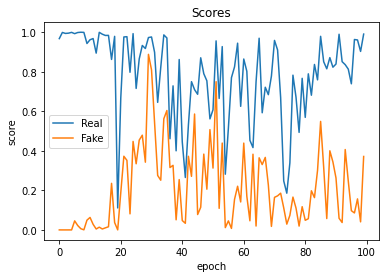

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

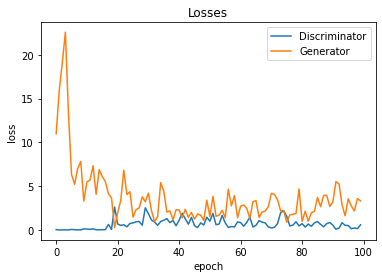

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()


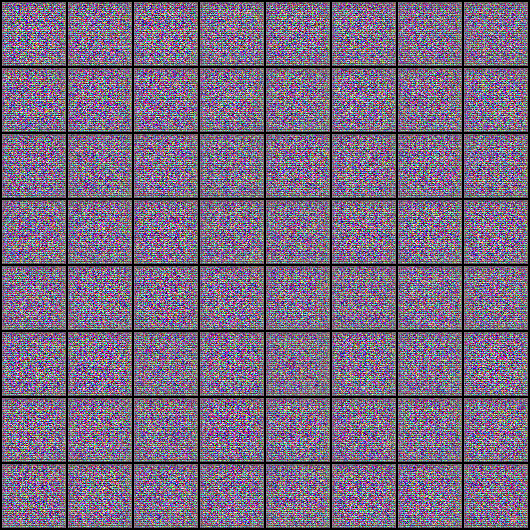

In [ ]:
from IPython.display import Image
Image('./generated/generated-images-0000.png')

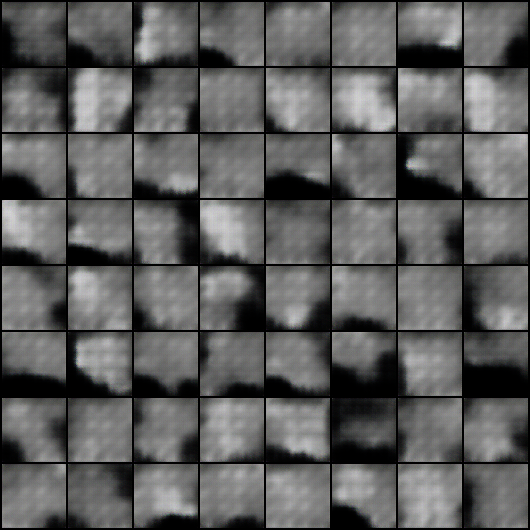

In [ ]:
Image('./generated/generated-images-0030.png')

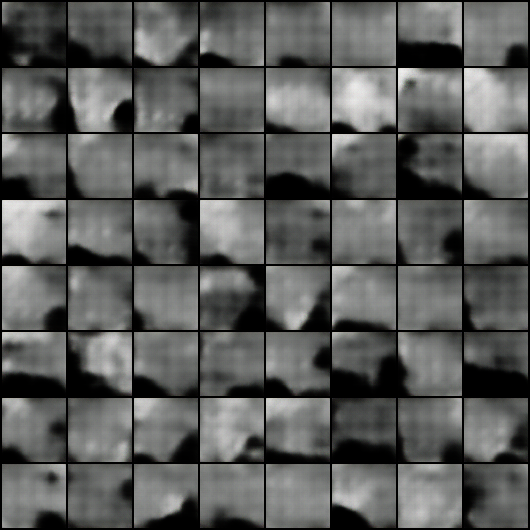

In [ ]:
Image('./generated/generated-images-0040.png')

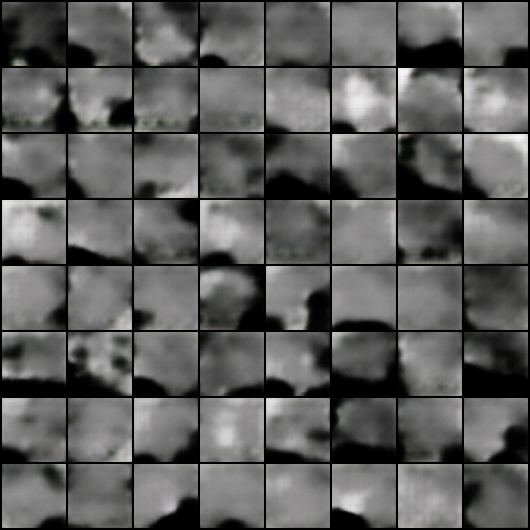

In [ ]:
Image('./generated/generated-images-0050.png')

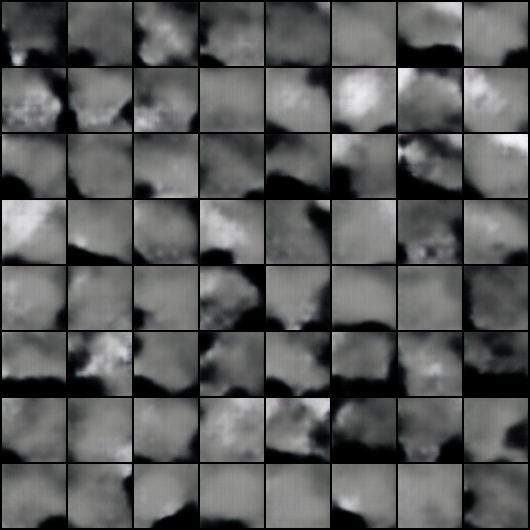

In [ ]:
Image('./generated/generated-images-0060.png')

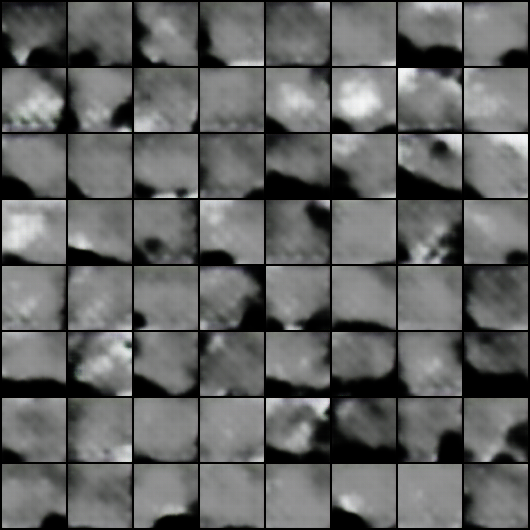

In [ ]:
Image('./generated/generated-images-0070.png')

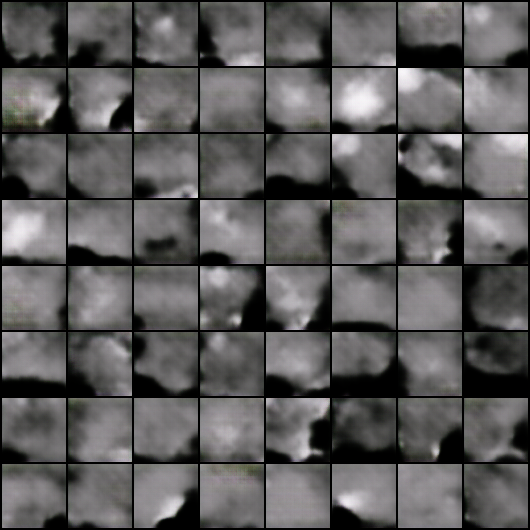

In [ ]:
Image('./generated/generated-images-0080.png')

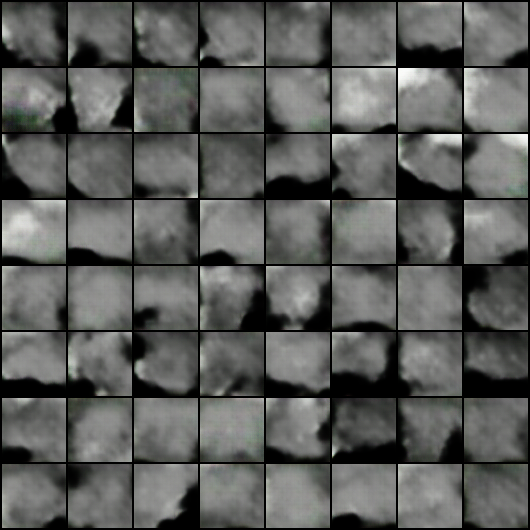

In [ ]:
Image('./generated/generated-images-0100.png')